## MNIST Image Segmentation Dataset
### Wesley Mitchell

In [164]:
import tensorflow as tf
import os 
import tensorflow.keras as keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle

#### Create the Dataset

In [165]:
#load the normal MNIST dataset
(x_single_train, y_single_train), (x_single_valid, y_single_valid) = keras.datasets.mnist.load_data()

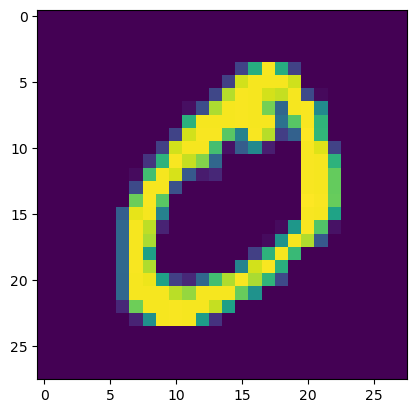

In [166]:
#display one of the examples from the MNIST dataset
x_single_train.shape
plt.imshow(x_single_train[1])
plt.show()

In [167]:
x_single_train.shape

(60000, 28, 28)

In [168]:
x_single_valid.shape

(10000, 28, 28)

In [169]:
#function to stitch the examples from the MNIST dataset together
def stitch_images_randomly(images, final_width, final_height, min_scale, max_scale):
    final_image = np.zeros((final_height, final_width), dtype=np.uint8)

    def generate_random_position(image_width, image_height):
        x = random.randint(0, final_width - image_width)
        y = random.randint(0, final_height - image_height)
        return x, y

    def is_overlap(position1, size1, position2, size2):
        x1, y1 = position1
        w1, h1 = size1
        x2, y2 = position2
        w2, h2 = size2
        

        return not (x1 + w1 <= x2 or x1 >= x2 + w2 or y1 + h1 <= y2 or y1 >= y2 + h2)
    
    def random_scale_image(image_array, min_scale, max_scale):
        scale_factor = random.uniform(min_scale, max_scale)

        image = Image.fromarray(image_array)

        new_width = int(image.width * scale_factor)
        new_height = int(image.height * scale_factor)

        resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

        resized_image_array = np.array(resized_image)

        return resized_image_array

    positions = []
    
    scaled_images = []
    
    for i in range(len(images)):
        scaled_images.append(random_scale_image(images[i], min_scale, max_scale))
    scaled_images = np.array(scaled_images, dtype=object)
        
    for image in scaled_images:
        image_height, image_width = image.shape
        while True:
            position = generate_random_position(image_width, image_height)
            if not any(is_overlap(position, image.shape[:2][::-1], pos, img_arr.shape[:2][::-1]) for pos, img_arr in zip(positions, images)):
                positions.append(position)
                break

    for image, position in zip(scaled_images, positions):
        x, y = position
        h, w = image.shape
        final_image[y:y+h, x:x+w] = image

    return final_image

In [170]:
#create the stitched images
final_image_height = 100
final_image_width = 100
num_images = 1
variations = 4
images_per_class_train = len(x_single_train) // 10
print(images_per_class_train)
images_per_class_valid = len(x_single_valid) // 10
scales = [(1, 2, 1), (.5, 1.3, 2), (.5, 1.3, 3), (.5, 1.3, 4)] 

x_train_stitched = []
y_train_stitched = [] 
x_valid_stitched = []
y_valid_stitched = []
for vari in range(variations):
    for i in range(0, images_per_class_train * scales[vari][2], scales[vari][2]):
        x_train_stitched.append(stitch_images_randomly(x_single_train[i:i+scales[vari][2]], final_image_width, final_image_height, scales[vari][0], scales[vari][1]))
        y_train_stitched.append(tuple(y_single_train[j] for j in range(i, i+scales[vari][2])))

    for i in range(0, images_per_class_valid * scales[vari][2], scales[vari][2]):
        x_valid_stitched.append(stitch_images_randomly(x_single_valid[i:i+scales[vari][2]], final_image_width, final_image_height, scales[vari][0], scales[vari][1]))
        y_valid_stitched.append(tuple(y_single_valid[j] for j in range(i, i+scales[vari][2])))

6000


/var/folders/v2/s2y1gdr11p7fdcykb6wjsbf00000gn/T/ipykernel_17140/2633005857.py:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)


In [171]:
#convert the stitched MNIST examples to numpy arrays
x_train_stitched = np.array(x_train_stitched)
y_train_stitched = np.array(y_train_stitched, dtype=object)

x_valid_stitched = np.array(x_valid_stitched)
y_valid_stitched = np.array(y_valid_stitched, dtype=object)

#shuffle the training and validation datasets
x_train_stitched, y_train_stitched = shuffle(x_train_stitched, y_train_stitched)
x_valid_stitched, y_valid_stitched = shuffle(x_valid_stitched, y_valid_stitched)

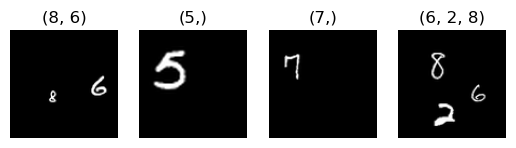

In [172]:
#display four examples of the training dataset with labels
plt.subplots_adjust(hspace=0.3)
plt.subplot(1, 4, 1)
plt.title(y_train_stitched[0])
plt.axis('off')
plt.imshow(x_train_stitched[0], cmap='gray')

plt.subplot(1, 4, 2)
plt.title(y_train_stitched[1])
plt.axis('off')
plt.imshow(x_train_stitched[1], cmap='gray')

plt.subplot(1, 4, 3)
plt.title(y_train_stitched[2])
plt.axis('off')
plt.imshow(x_train_stitched[2], cmap='gray')

plt.subplot(1, 4, 4)
plt.title(y_train_stitched[3])
plt.axis('off')
plt.imshow(x_train_stitched[3], cmap='gray')

plt.show()

#### Save the Dataset to a Directory

In [173]:
#pathes to the directories for training and validation datasets
train_directory = 'StitchedMNIST/train'
valid_directory = 'StitchedMNIST/validation'

#function to save an individual image
def save_image(image_array, file_path):
    image = Image.fromarray(image_array)
    image.save(file_path)


In [174]:
#save each of the images in training set to the training directory
for i, img in enumerate(x_train_stitched):
    file_name = f'examples/image_{i:05}.png'
    file_path = os.path.join(train_directory, file_name)
    save_image(img, file_path)

In [175]:
#save each of the labels for the training dataset
train_labels_file = open(f"{train_directory}/labels.txt", "w")

for label in y_train_stitched:
    label_str = str(label)
    label_str = label_str.replace("(", "").replace(")", "")
    
    if len(label_str) == 2:
        label_str = label_str[0]
        
    train_labels_file.write(label_str + "\n")
    
train_labels_file.close()

In [176]:
#save each of the images in validation set to the validation directory
for i, img in enumerate(x_valid_stitched):
    file_name = f'examples/image_{i:05}.png'
    file_path = os.path.join(valid_directory, file_name)
    save_image(img, file_path)

In [177]:
#save each of the labels for the validation dataset
valid_labels_file = open(f"{valid_directory}/labels.txt", "w")

for label in y_train_stitched:
    label_str = str(label)
        
    label_str = label_str.replace("(", "").replace(")", "")
    
    if len(label_str) == 2:
        label_str = label_str[0]
        
    valid_labels_file.write(label_str + "\n")
    
valid_labels_file.close()

#### Create the Pretraining Dataset

In [178]:
#create 100 x 100 images from the MNIST dataset with random scales and positions
final_image_height = 100
final_image_width = 100
num_images = 1
variations = 1
images_per_class_train = len(x_single_train)
images_per_class_valid = len(x_single_valid)
scales = [(1, 2, 1)] 
x_train_pretrain = []
y_train_pretrain = [] 
x_valid_pretrain = []
y_valid_pretrain = []
for vari in range(variations):
    for i in range(0, images_per_class_train * scales[vari][2], scales[vari][2]):
        x_train_pretrain.append(stitch_images_randomly(x_single_train[i:i+scales[vari][2]], final_image_width, final_image_height, scales[vari][0], scales[vari][1]))
        y_train_pretrain.append(tuple(y_single_train[j] for j in range(i, i+scales[vari][2])))

    for i in range(0, images_per_class_valid * scales[vari][2], scales[vari][2]):
        x_valid_pretrain.append(stitch_images_randomly(x_single_valid[i:i+scales[vari][2]], final_image_width, final_image_height, scales[vari][0], scales[vari][1]))
        y_valid_pretrain.append(tuple(y_single_valid[j] for j in range(i, i+scales[vari][2])))

/var/folders/v2/s2y1gdr11p7fdcykb6wjsbf00000gn/T/ipykernel_17140/2633005857.py:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)


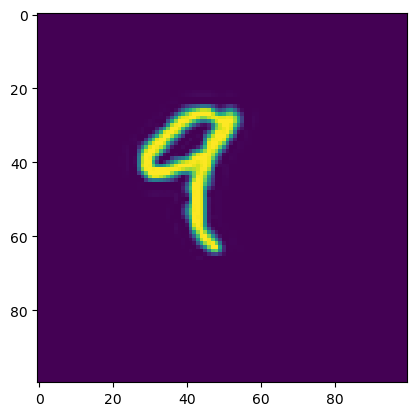

In [179]:
plt.imshow(x_train_pretrain[4])

In [180]:
#convert the stitched MNIST examples to numpy arrays
x_train_pretrain = np.array(x_train_pretrain)
y_train_pretrain = np.array(y_train_pretrain, dtype=object)

x_valid_pretrain = np.array(x_valid_pretrain)
y_valid_pretrain = np.array(y_valid_pretrain, dtype=object)

#shuffle the training and validation datasets
x_train_pretrain, y_train_pretrain = shuffle(x_train_pretrain, y_train_pretrain)
x_valid_pretrain, y_valid_pretrain = shuffle(x_valid_pretrain, y_valid_pretrain)

In [181]:
#pathes to the directories for training and validation datasets for pretraining dataset
train_directory = 'Pretraining/train'
valid_directory = 'Pretraining/validation'

In [182]:
#save each of the images in training set to the training directory
for i, img in enumerate(x_train_pretrain):
    file_name = f'examples/image_{i:05}.png'
    file_path = os.path.join(train_directory, file_name)
    save_image(img, file_path)

In [183]:
#save each of the labels for the training dataset
train_labels_file = open(f"{train_directory}/labels.txt", "w")

for label in y_train_pretrain:
    label_str = str(label)
    label_str = label_str.replace("[", "").replace("]", "")
    
    if len(label_str) == 2:
        label_str = label_str[0]
        
    train_labels_file.write(label_str + "\n")
    
train_labels_file.close()

In [184]:
#save each of the images in validation set to the validation directory
for i, img in enumerate(x_valid_pretrain):
    file_name = f'examples/image_{i:05}.png'
    file_path = os.path.join(valid_directory, file_name)
    save_image(img, file_path)

In [185]:
#save each of the labels for the validation dataset
valid_labels_file = open(f"{valid_directory}/labels.txt", "w")

for label in y_valid_pretrain:
    label_str = str(label)
        
    label_str = label_str.replace("[", "").replace("]", "")
    
    if len(label_str) == 2:
        label_str = label_str[0]
        
    valid_labels_file.write(label_str + "\n")
    
valid_labels_file.close()